In [7]:
import pandas as pd
# Load the dataset
data = pd.read_csv('historical_weather.csv/historical_weather.csv')

# Display the first few rows of the dataset
data.head(20)

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0
5,C001,2014-01-06,9.1,5.7,14.7,NaN,NaN,156.0,5.7
6,C001,2014-01-07,8.8,2.0,18.8,NaN,NaN,158.0,6.2
7,C001,2014-01-08,8.8,3.0,16.3,NaN,NaN,NaN,NaN
8,C001,2014-01-09,9.9,3.9,17.1,NaN,NaN,NaN,4.8
9,C001,2014-01-10,10.8,7.0,17.2,NaN,NaN,149.0,5.8


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Load the historical weather data
data = pd.read_csv('historical_weather.csv/historical_weather.csv', parse_dates=['date'])

# Convert city_id to a categorical type
data['city_id'] = data['city_id'].astype('category')

# Set the date as the index
data.set_index('date', inplace=True)

# Display the first few rows of the dataset
print(data.head())

           city_id  avg_temp_c  min_temp_c  max_temp_c  precipitation_mm  \
date                                                                       
2014-01-01    C001         6.6        -1.4        11.6               NaN   
2014-01-02    C001         9.3         6.3        13.3               NaN   
2014-01-03    C001         7.6         1.9        14.0               NaN   
2014-01-04    C001         7.6         3.9        13.3               NaN   
2014-01-05    C001         8.6         0.5        16.9               NaN   

            snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  
date                                                             
2014-01-01            NaN             168.0                 6.2  
2014-01-02            NaN             155.0                10.0  
2014-01-03            NaN               NaN                 5.8  
2014-01-04            NaN             291.0                11.3  
2014-01-05            NaN               NaN                 5.0  


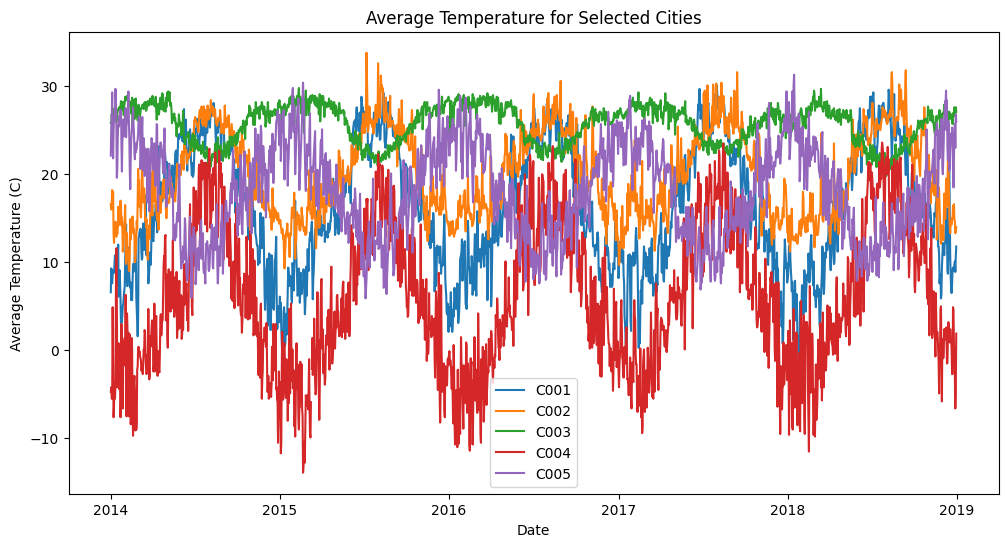

In [9]:

# Plot the average temperature for a few cities
cities = data['city_id'].unique()[:5]  # Select first 5 cities for visualization
plt.figure(figsize=(12, 6))

for city in cities:
    city_data = data[data['city_id'] == city]
    plt.plot(city_data.index, city_data['avg_temp_c'], label=city)

plt.title('Average Temperature for Selected Cities')
plt.xlabel('Date')
plt.ylabel('Average Temperature (C)')
plt.legend()
plt.show()

In [10]:

def sarima_forecast(train, order, seasonal_order, steps):
    # Fit the model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Forecast
    forecast = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    
    return forecast_mean


In [11]:

# Load the submission key
submission_key = pd.read_csv('submission_key.csv', parse_dates=['date'])

# Set parameters for SARIMA
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Initialize a list to hold the forecasts
forecasts = []

# Forecast horizon
forecast_horizon = submission_key['date'].nunique()


In [12]:
# Iterate over each unique city in the submission key
count=0
for city in submission_key['city_id'].unique():
    count = count +1
    print("Reached here")
    print(count)
    # Get the training data for the city
    city_data = data[data['city_id'] == city]['avg_temp_c']
    train = city_data['2014-01-01':'2018-12-31']
    
    # Forecast using SARIMA
    forecast_mean = sarima_forecast(train, order, seasonal_order, steps=forecast_horizon)
    
    # Extract the forecast dates
    forecast_dates = pd.date_range(start='2019-01-01', periods=forecast_horizon, freq='D')
    
    # Create a DataFrame with forecasted values and dates
    forecast_df = pd.DataFrame({'date': forecast_dates, 'avg_temp_c': forecast_mean})
    
    # Merge forecast_df with submission_key to get the forecasts for required dates
    city_forecasts = submission_key[submission_key['city_id'] == city].merge(forecast_df, on='date', how='left')
    
    # Append the city forecasts to the forecasts list
    forecasts.append(city_forecasts)

Reached here
1
Reached here
2
Reached here
3
Reached here
4
Reached here
5
Reached here
6
Reached here
7
Reached here
8
Reached here
9
Reached here
10
Reached here
11
Reached here
12
Reached here
13
Reached here
14
Reached here
15
Reached here
16
Reached here
17
Reached here
18
Reached here
19
Reached here
20
Reached here
21
Reached here
22
Reached here
23
Reached here
24
Reached here
25
Reached here
26
Reached here
27
Reached here
28
Reached here
29
Reached here
30
Reached here
31
Reached here
32
Reached here
33
Reached here
34
Reached here
35
Reached here
36
Reached here
37
Reached here
38
Reached here
39
Reached here
40
Reached here
41
Reached here
42
Reached here
43
Reached here
44
Reached here
45
Reached here
46
Reached here
47
Reached here
48
Reached here
49
Reached here
50
Reached here
51
Reached here
52
Reached here
53
Reached here
54
Reached here
55
Reached here
56
Reached here
57
Reached here
58
Reached here
59
Reached here
60
Reached here
61
Reached here
62
Reached here
63
R

In [13]:
# Concatenate all the forecasts
submission_df = pd.concat(forecasts)

# Ensure the submission is sorted by submission_ID
submission_df.sort_values('submission_ID', inplace=True)

# Select only the required columns for submission
submission = submission_df[['submission_ID', 'avg_temp_c']]

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

print(submission.head())

   submission_ID  avg_temp_c
0              1   11.729624
1              2   11.546911
2              3   11.254620
3              4   10.918898
4              5   10.719733
